In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone
# keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras import layers


Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# CONFIGURATION

# Number of day's worth of data we will generate
DAYS = 2.0
# Unix timestamp of earliest metric
START_TIME = 0.0
# Unix timestamp of latest metric
END_TIME = float(START_TIME + (60*1440*DAYS))
# Period of sine wave data we'll be generating
PERIOD_MINUTES = 720 # 12 hours
# Amplitude of our dataset
AMPLITUDE = 3000
# vertical shift of the sine wave
VSHIFT = 5000
# The percentage of the dataset that's dedicated to training
TRAIN_SIZE = .50
# The number of values that should be used to predict the next one
LOOKBACK = 1
# How many timesteps we want to predict into the future
LOOKAHEAD = 1
# Whether to add gaussian noise to Y 
NOISY = True

In [3]:
# GENERATE X AS 2D ARRAY OF UNIX TIMESTAMPS 60 SECONDS APART
X = np.arange(
            start=START_TIME,
            stop= END_TIME + 60.0,
            step= 60.0,
            dtype = np.float64,
            )

X = X.reshape((X.shape[0], 1))
print("X SHAPE: %s" % str(X.shape))
print("--------------")
print ("First Three Datapoints in X:\n%s" % str(X[:3]))

X SHAPE: (2881, 1)
--------------
First Three Datapoints in X:
[[  0.]
 [ 60.]
 [120.]]


In [4]:
# GENERATE Y AS 2D ARRAY WHERE Y = sin(x)

# Create Y values as sin(X)
Y = np.zeros_like(X, dtype=np.float64)

# for each value x, get sin(x)
for i, x in enumerate(X.ravel()):    
    B = (2 * math.pi) / (PERIOD_MINUTES * 60.0)
    n = math.pi / 2.0
    C = n / B
    
    Y[i][0] = AMPLITUDE * math.sin(B * (x - C)) + VSHIFT
    
    
    
if NOISY:
    # create noise
    dy = np.random.random(Y.shape)
    # normarl (amplitude, scale)
    noise = np.random.normal(VSHIFT, dy * AMPLITUDE * .5)
    # add noise to the matrix
    Y += noise
    
print("Y SHAPE: %s" % str(Y.shape))

Y SHAPE: (2881, 1)


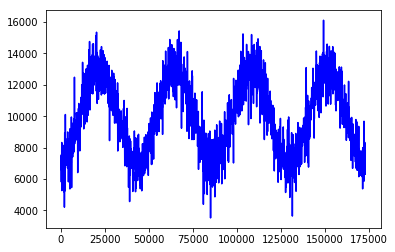

In [5]:
# Plot the "raw" dataset to make sure it looks right.
plt.plot(X, Y, 'b-')
plt.show()

In [6]:
# SPLIT DATA INTO TRAIN AND TEST SETS
idx = int(X.shape[0] * TRAIN_SIZE)

X_train = X[:idx]
Y_train = Y[:idx]

X_test = X[idx:]
Y_test = Y[idx:]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1440, 1)
(1440, 1)
(1441, 1)
(1441, 1)


In [7]:
# CREATE WINDOWED DATASETS (SUPERVISED DATA)

def create_windowed_dataset(Y:np.array):
    x, y = [], []
    i = 0
    j = (Y.shape[0] - LOOKBACK)
    while i < j:
        a = Y[i:(i + LOOKBACK)][0]
        x.append(a)
        y.append(Y[i + LOOKBACK])
        i += 1

    return np.array(x), np.array(y).reshape(len(y), 1)

X_train_windowed, Y_train_windowed = create_windowed_dataset(Y_train)
X_test_windowed, Y_test_windowed = create_windowed_dataset(Y_test)

print(X_train_windowed.shape)
print(Y_train_windowed.shape)
print("----------------")
print(X_test_windowed.shape)
print(Y_test_windowed.shape)


(1439, 1)
(1439, 1)
----------------
(1440, 1)
(1440, 1)


In [8]:
# RESHAPE X_TRAIN_AND X_TEST INTO 3D ARRAY BECAUSE 
# THE NN REQUIRES INPUTS AS (samples, timesteps, features)

# reshape X_train and X_test into cube of (samples, timesteps, features)
X_train_windowed = np.reshape(X_train_windowed, (X_train_windowed.shape[0], 1, X_train_windowed.shape[1]))
X_test_windowed = np.reshape(X_test_windowed, (X_test_windowed.shape[0], 1, X_test_windowed.shape[1]))

print("X_train_windowed shape: %s" % str(X_train_windowed.shape))
print("-----------------")
print("X_train_windowed first 3 rows\n%s" % str(X_train_windowed[:3]))
print("-----------------")
print("X_test_windowed shape: %s\n" % str(X_test_windowed.shape))

X_train_windowed shape: (1439, 1, 1)
-----------------
X_train_windowed first 3 rows
[[[7500.84197552]]

 [[6824.09592554]]

 [[7429.51846137]]]
-----------------
X_test_windowed shape: (1440, 1, 1)



In [9]:
# CREATE THE LSTM NEURAL NETWORK
model = Sequential()
model.add(layers.LSTM(
    60,
    input_shape=(1, LOOKBACK),
    activation='linear'
))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [10]:
# train the LSTM network
history = model.fit(X_train_windowed,
                    Y_train_windowed,
                    epochs=1,
                    batch_size=1,
                    verbose=2, 
                    shuffle=False
                   )

print(history)

Epoch 1/1
 - 4s - loss: 5277502.8686


In [11]:
# Iterate through test set and generate predictions

# X_predict will be array of unix timestamps that predictions were 
# generated for
X_predict = np.zeros((X_test.shape[0]-1, 1))
# Y_predict are the actual Y predictions
Y_predict = np.zeros_like(X_predict)

# iterate through the test set and generate a prediction for each value
# in the test set. Add the predicted value to the Y_predict array
for i, x in enumerate(X_test_windowed):
    # when we iterate through 3D array, we lose the first dimension,
    # so we need to reshape x into 3D array that can be inputted into
    # the model to generate a prediction
    x = np.reshape(x, (1, LOOKBACK, 1))
    # we need to fetch the timestamp corresponding the to prediction we're about
    # to make. That way we can properly plot the predictions later
    X_predict[i] = X_test[i+LOOKBACK]
    # generate the prediction and add to Y_predict array
    Y_predict[i][0] = model.predict(x, batch_size=1)
    
print(X_predict.shape)
print(X_predict[:3])
print("-----------------")
print(Y_predict.shape)
print(Y_predict[:3])

(1440, 1)
[[86460.]
 [86520.]
 [86580.]]
-----------------
(1440, 1)
[[6178.87158203]
 [8217.64648438]
 [7284.49267578]]


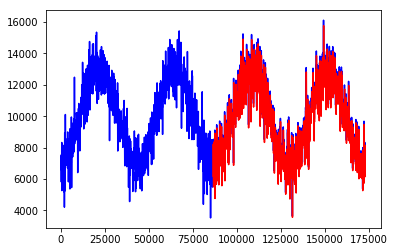

In [12]:
# PLOT OUR DATASET
plt.plot(X, Y, 'b-')

plt.plot(X_predict, Y_predict, 'r-')
plt.show()